# **MUTATIINA N. EDIGAR**

**MOUNTING MY DRIVE.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTING LIBRARIES**

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf

import os as os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

**LOADING THE DATASET**

In [4]:
data_dir = '/content/drive/MyDrive/Dataset/Rock_Paper_Scissors'
rock_dir = os.path.join(data_dir,'rock')
paper_dir = os.path.join(data_dir,'paper')
scissors_dir = os.path.join(data_dir,'scissors')
os.listdir(data_dir)

['paper', 'rock', 'scissors']

In [5]:
pd.DataFrame(
    data=[len(os.listdir(rock_dir)),
          len(os.listdir(paper_dir)),
          len(os.listdir(scissors_dir))
          ],
    index=['Rock Image', 'Paper Image', 'Scissor Image'],
    columns=['Total Image']
    )

,Total Image
Rock Image,726
Paper Image,712
Scissor Image,750


**VISUALIZATION**

Class Distribution: {'rock': 726, 'paper': 712, 'scissors': 750}


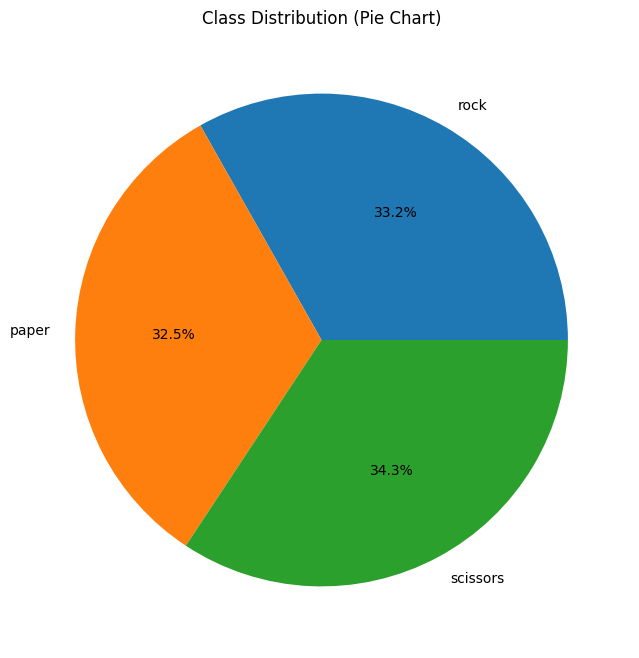

In [6]:
classes = ['rock', 'paper', 'scissors']

# Count number of images in each class
def count_images(data_dir, classes):
    class_counts = {}
    data_path = Path(data_dir) # Convert to Path object
    for cls in classes:
        class_path = data_path / cls  # Combine the directory path using Path object
        class_counts[cls] = len(list(class_path.iterdir()))  # Count the number of files in the folder
    return class_counts

# Print the number of images in each class
class_counts = count_images(data_dir, classes)
print("Class Distribution:", class_counts)

# Visualize class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%') # Added autopct for percentages
plt.title('Class Distribution (Pie Chart)')
plt.show()

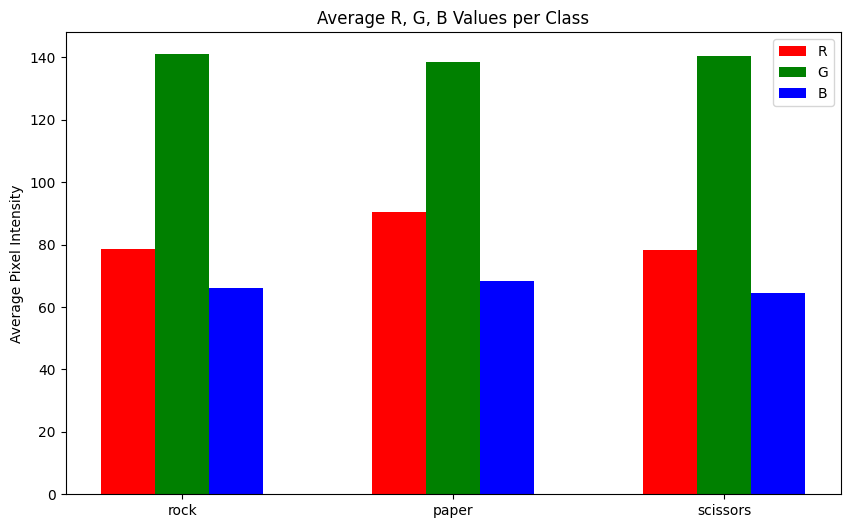

In [9]:
# Calculate RGB statistics (mean values)
color_stats = {cls: {'R': [], 'G': [], 'B': []} for cls in classes}

data_path = Path(data_dir) # Convert to Path object
from PIL import Image, ImageStat # Import Image and ImageStat from PIL
for cls in classes:
    class_path = data_path / cls
    for img_file in class_path.iterdir():
        with Image.open(img_file) as img:
            stat = ImageStat.Stat(img)
            color_stats[cls]['R'].append(stat.mean[0])  # Red channel mean
            color_stats[cls]['G'].append(stat.mean[1])  # Green channel mean
            color_stats[cls]['B'].append(stat.mean[2])  # Blue channel mean

# Calculate average RGB values for each class
avg_color_stats = {cls: {'R': np.mean(color_stats[cls]['R']),
                         'G': np.mean(color_stats[cls]['G']),
                         'B': np.mean(color_stats[cls]['B'])} for cls in classes}

# Plot bar graphs for average R, G, B
colors = ['R', 'G', 'B']
bar_width = 0.2

plt.figure(figsize=(10, 6))

x = np.arange(len(classes))

for i, color in enumerate(colors):
    means = [avg_color_stats[cls][color] for cls in classes]
    plt.bar(x + i * bar_width, means, bar_width, label=color, color=color.lower())

plt.xticks(x + bar_width, classes)
plt.ylabel('Average Pixel Intensity')
plt.title('Average R, G, B Values per Class')
plt.legend()
plt.show()

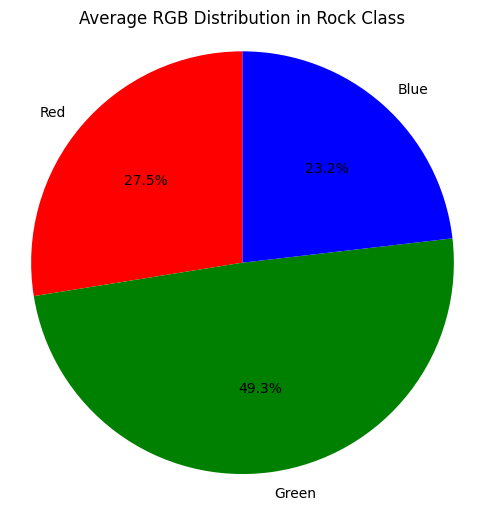

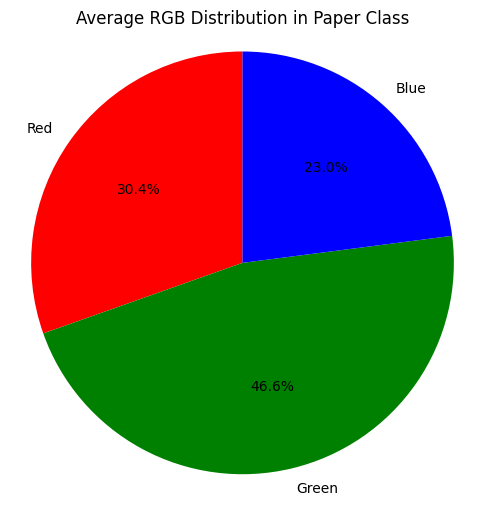

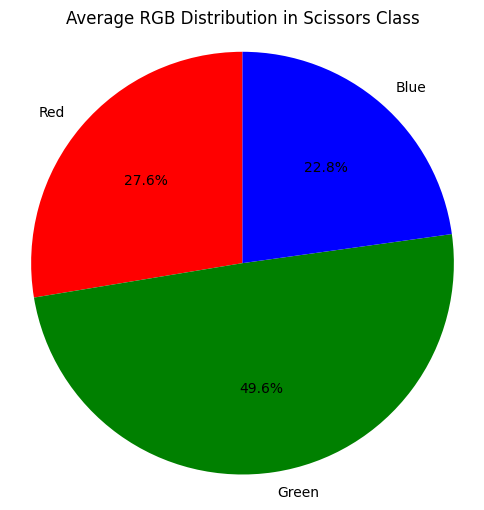

In [44]:
# Create pie charts for average R, G, B distribution within each class
for cls in classes:
    avg_rgb = [avg_color_stats[cls]['R'], avg_color_stats[cls]['G'], avg_color_stats[cls]['B']]
    labels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(6, 6))
    plt.pie(avg_rgb, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Average RGB Distribution in {cls.capitalize()} Class')
    plt.axis('equal')
    plt.show()

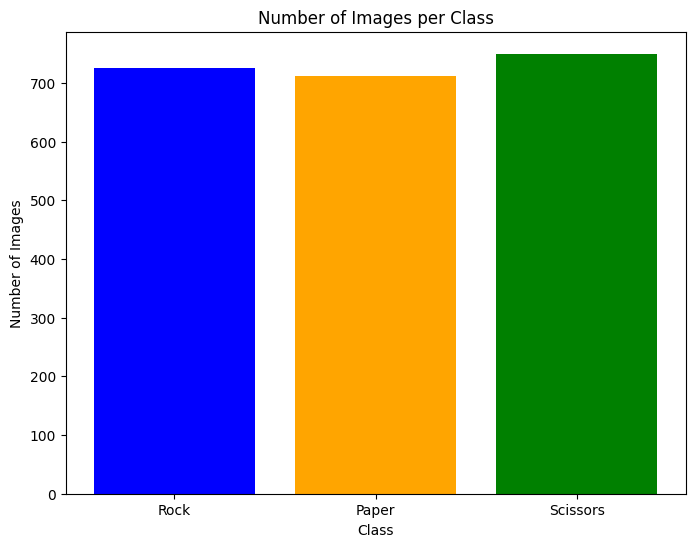

In [42]:
rock_count = len(os.listdir(rock_dir))
paper_count = len(os.listdir(paper_dir))
scissors_count = len(os.listdir(scissors_dir))

class_names = ['Rock', 'Paper', 'Scissors'] #list for the classes
counts = [rock_count, paper_count, scissors_count] # list for the counts

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color=['blue', 'orange', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

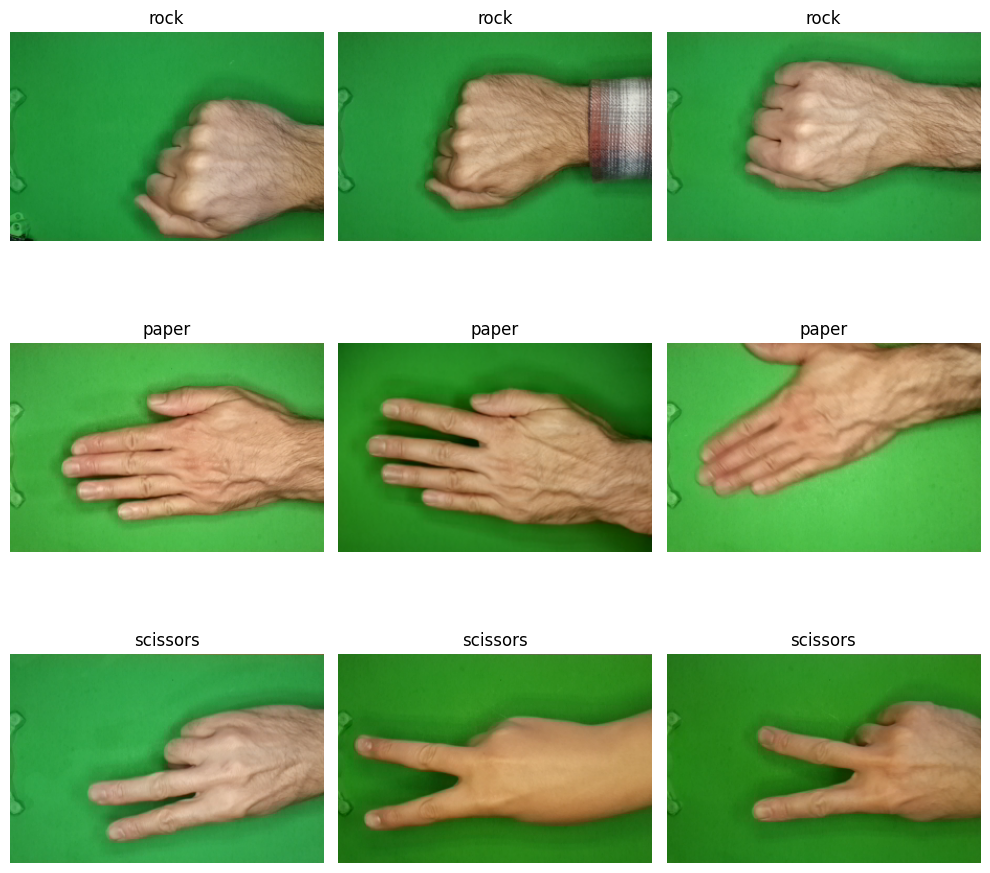

In [10]:
num_samples = 3
plt.figure(figsize=(10, 10))

for i, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    images = os.listdir(class_path)[:num_samples]

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()

**Defining our files and labels from the dataset**



In [11]:
rock_files = glob(os.path.join(rock_dir, '*.png'))
paper_files = glob(os.path.join(paper_dir, '*.png'))
scissors_files = glob(os.path.join(scissors_dir, '*.png'))

rock_labels = [0] * len(rock_files)
paper_labels = [1] * len(paper_files)
scissors_labels = [2] * len(scissors_files)

all_files = rock_files + paper_files + scissors_files
all_labels = rock_labels + paper_labels + scissors_labels

**Applying train_test_split(60%-Training, 20%-Testing, 20%-Validation)**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print(f"Number of images in training set: {len(X_train)}")
print(f"Number of images in validation set: {len(X_val)}")
print(f"Number of images in test set: {len(X_test)}")

Number of images in training set: 1750
Number of images in validation set: 219
Number of images in test set: 219


**Normalization**

In [13]:
IMG_SIZE = 128

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path) # loading the images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # we are converting to RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # we are resizing
    img = img / 255.0  # we are normalizing pixel values
    return img

In [14]:
X_train_processed = np.array([load_and_preprocess_image(img_path) for img_path in tqdm(X_train)])
X_val_processed = np.array([load_and_preprocess_image(img_path) for img_path in tqdm(X_val)])
X_test_processed = np.array([load_and_preprocess_image(img_path) for img_path in tqdm(X_test)])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed validation data:", X_val_processed.shape)
print("Shape of processed test data:", X_test_processed.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation labels:", y_val.shape)
print("Shape of test labels:", y_test.shape)

100%|██████████| 219/219 [00:02<00:00, 97.96it/s] 


Shape of processed training data: (1750, 128, 128, 3)
Shape of processed validation data: (219, 128, 128, 3)
Shape of processed test data: (219, 128, 128, 3)
Shape of training labels: (1750,)
Shape of validation labels: (219,)
Shape of test labels: (219,)


**BUILDING A CNN MODEL.**

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(classes), activation='softmax')  # Output layer with softmax for classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

**TRAINING**

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
history = model.fit(
    X_train_processed,
    y_train,
    epochs=50,  # Set a sufficiently large number of epochs, as early stopping will handle stopping
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 757ms/step - accuracy: 0.5679 - loss: 0.9502 - val_accuracy: 0.8858 - val_loss: 0.3807
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 906ms/step - accuracy: 0.9031 - loss: 0.2935 - val_accuracy: 0.9406 - val_loss: 0.2204
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - accuracy: 0.9654 - loss: 0.1206 - val_accuracy: 0.9269 - val_loss: 0.1919
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 745ms/step - accuracy: 0.9717 - loss: 0.0904 - val_accuracy: 0.9315 - val_loss: 0.2059
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 804ms/step - accuracy: 0.9863 - loss: 0.0473 - val_accuracy: 0.9406 - val_loss: 0.1963
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 883ms/step - accuracy: 0.9987 - loss: 0.0172 - val_accuracy: 0.9543 - val_loss: 0.2356
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 836ms/step - accuracy: 0.9956 - loss: 0.0165 - val_accuracy: 0.9635 - val_loss: 0.1755
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 791ms/step - accuracy: 0.9995 - loss: 0.0085 - val_accu

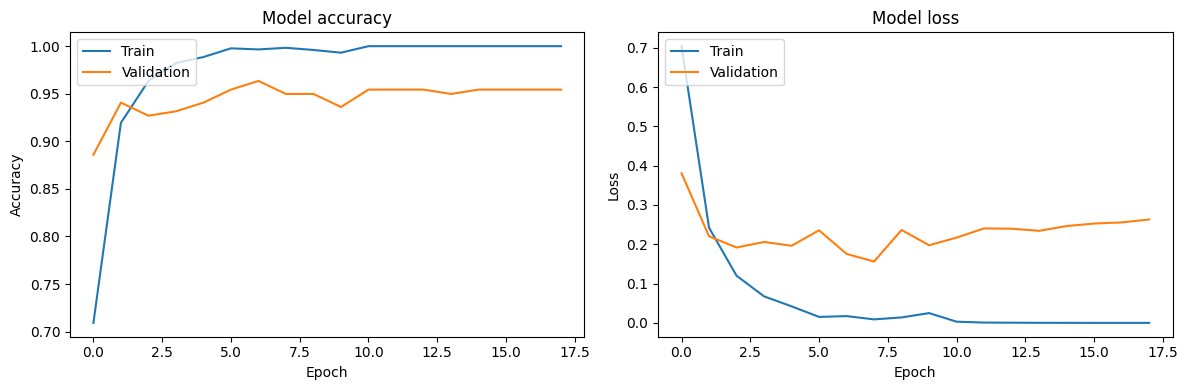

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
import os
print(os.listdir('drive/MyDrive/Dataset/Rock_Paper_Scissors'))

['paper', 'rock', 'scissors']


Saving 0Ug54ifXRqqlZS2Z.png to 0Ug54ifXRqqlZS2Z.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
0Ug54ifXRqqlZS2Z.png
scissors


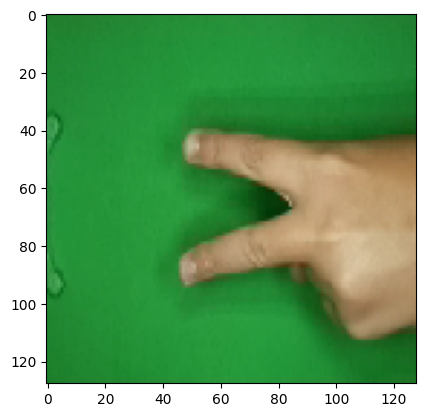

In [25]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes_prediction = model.predict(images, batch_size=10) # Renamed variable to avoid conflict with the 'classes' list
  predicted_class_index = np.argmax(classes_prediction[0]) # Get the index of the predicted class

  print(fn)
  # Map the predicted index back to the class name
  predicted_class_name = classes[predicted_class_index]
  print(predicted_class_name)

In [28]:
loss, accuracy = model.evaluate(X_val_processed, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.1562
Validation Accuracy: 0.9498


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


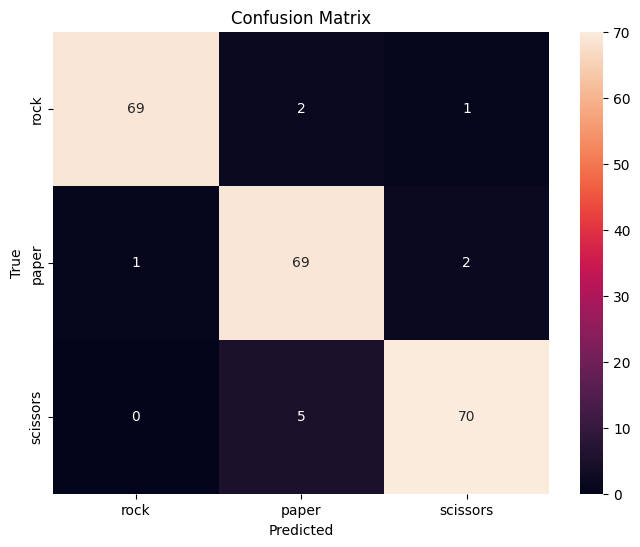

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


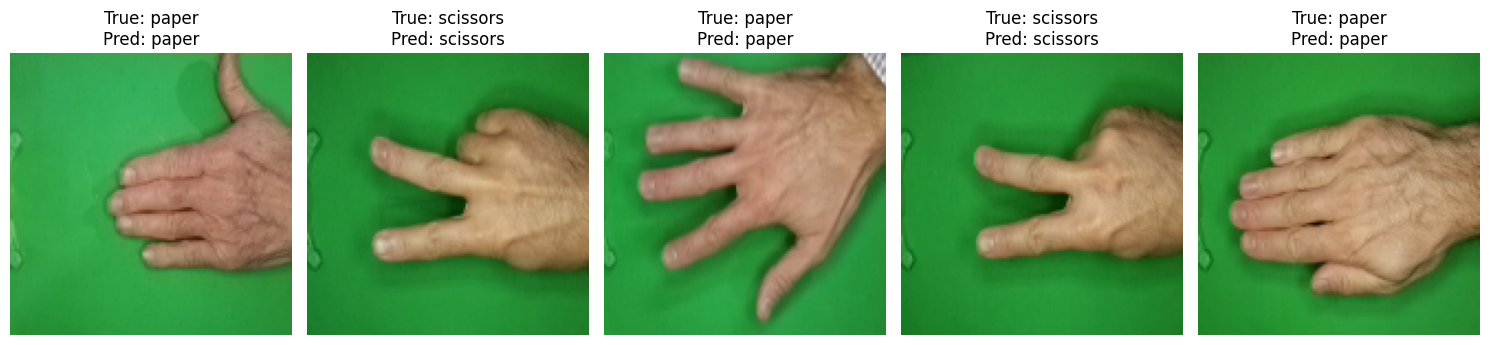

In [31]:
num_sample_predictions = 5
sample_indices = np.random.choice(len(X_test_processed), num_sample_predictions, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    img = X_test_processed[idx]
    true_label = y_test[idx]
    true_class_name = classes[true_label]

    img_expanded = np.expand_dims(img, axis=0)
    prediction = model.predict(img_expanded)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = classes[predicted_class_index]

    plt.subplot(1, num_sample_predictions, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
print(f"Model Evaluation Summary:")
print(f"Validation Accuracy: {accuracy:.4f}")

Model Evaluation Summary:
Validation Accuracy: 0.9498


In [36]:
print("\nConfusion Matrix Analysis:")
print("The confusion matrix shows the performance of the model on the validation set for each class:")
print(cm)


Confusion Matrix Analysis:
The confusion matrix shows the performance of the model on the validation set for each class:
[[69  2  1]
 [ 1 69  2]
 [ 0  5 70]]


In [37]:
print("\nObservations:")
print(f"- Rock (class 0): {cm[0, 0]} images correctly predicted as rock.")
print(f"- Paper (class 1): {cm[1, 1]} images correctly predicted as paper.")
print(f"- Scissors (class 2): {cm[2, 2]} images correctly predicted as scissors.")


Observations:
- Rock (class 0): 69 images correctly predicted as rock.
- Paper (class 1): 69 images correctly predicted as paper.
- Scissors (class 2): 70 images correctly predicted as scissors.


In [41]:
print("\nMisclassifications:")
if cm[0, 1] > 0 or cm[0, 2] > 0:
    print(f"- Some rock images were misclassified as paper ({cm[0, 1]}) or scissors ({cm[0, 2]}).")
if cm[1, 0] > 0 or cm[1, 2] > 0:
    print(f"- Some paper images were misclassified as rock ({cm[1, 0]}) or scissors ({cm[1, 2]}).")
if cm[2, 0] > 0 or cm[2, 1] > 0:
    print(f"- Some scissors images were misclassified as rock ({cm[2, 0]}) or paper ({cm[2, 1]}).")


Misclassifications:
- Some rock images were misclassified as paper (2) or scissors (1).
- Some paper images were misclassified as rock (1) or scissors (2).
- Some scissors images were misclassified as rock (0) or paper (5).
